In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy

In [4]:
!pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 1.5 MB/s eta 0:00:00


In [6]:
!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 2.2 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ---------------------------------------- 74.0/74.0 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [5]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

In [6]:
plt.rcParams["figure.figsize"] = (6.4,4.8)

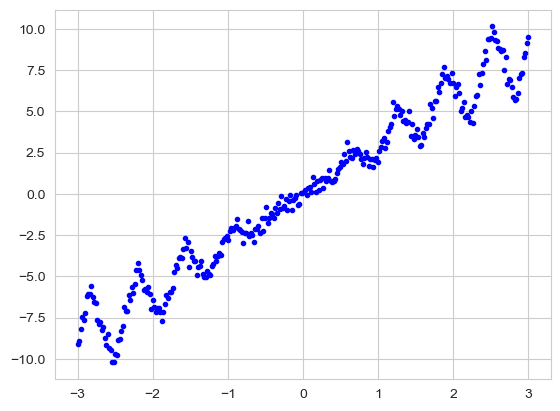

In [26]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [40]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=1, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [2]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

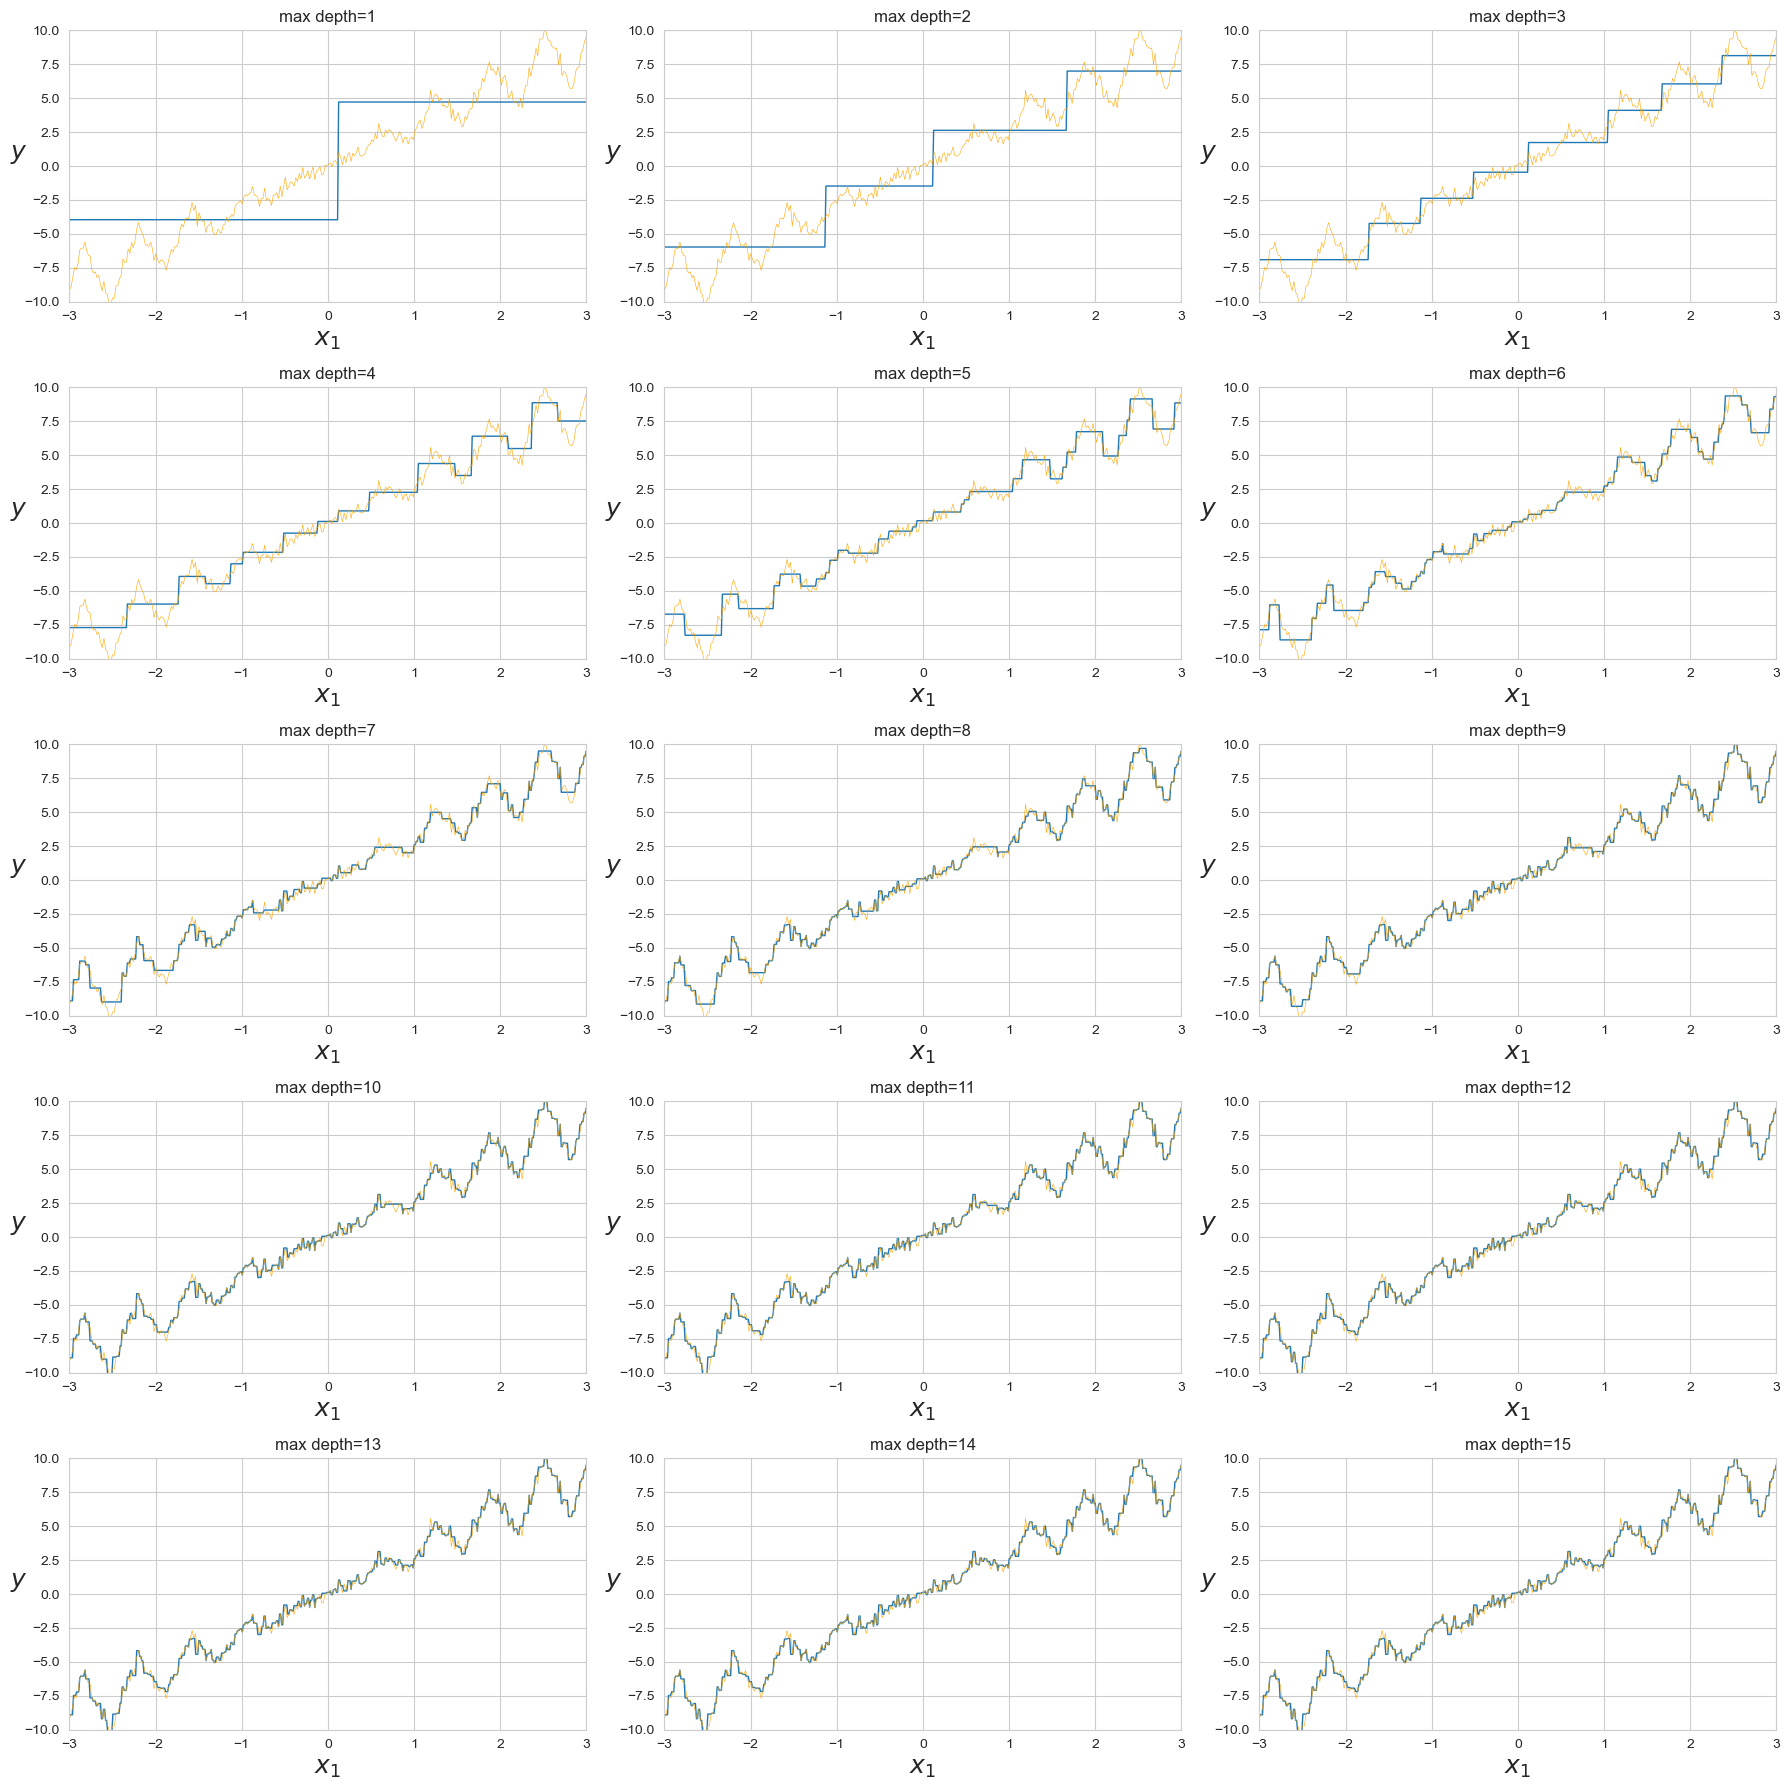

In [45]:
fig, ax = plt.subplots(5, 3, figsize=(18,18))

for max_d in range(1, 16):
    plt.subplot(5, 3, max_d)
    model = DecisionTreeRegressor(max_depth=max_d)
    model.fit(X_train, y_train)
    plot_regression_predictions(model, X_test, y_test)
    plt.plot(X.reshape(-1), y.reshape(-1), 'orange', linewidth=0.4)  # plot the actual dependence 
    plt.title(f'max depth={max_d}')
plt.tight_layout()
plt.show()

Исходя из того, какой шум мы задали в исходной зависимости, хорошо описывает регерессор с глубиной 5, дальше уже overfitting

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

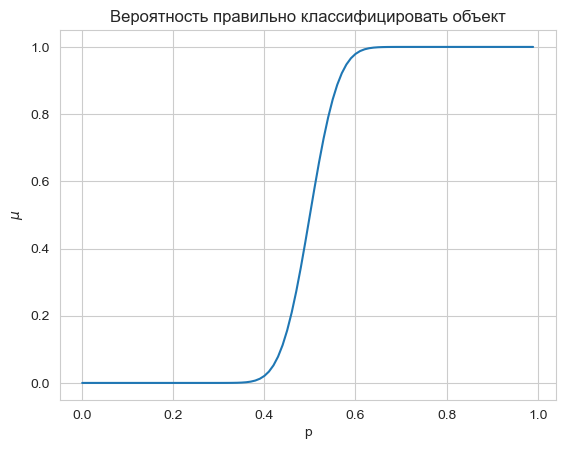

In [49]:
individual_ps = np.arange(0, 1, 0.01)
mu = []
for p in individual_ps:
    mu.append(np.sum(np.array([math.comb(101, i) * pow(p, i) * pow(1-p, 101-i) for i in range(51, 102)])))

plt.plot(individual_ps, mu)
plt.xlabel("p");
plt.ylabel("$\mu$");
plt.title("Вероятность правильно классифицировать объект");

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

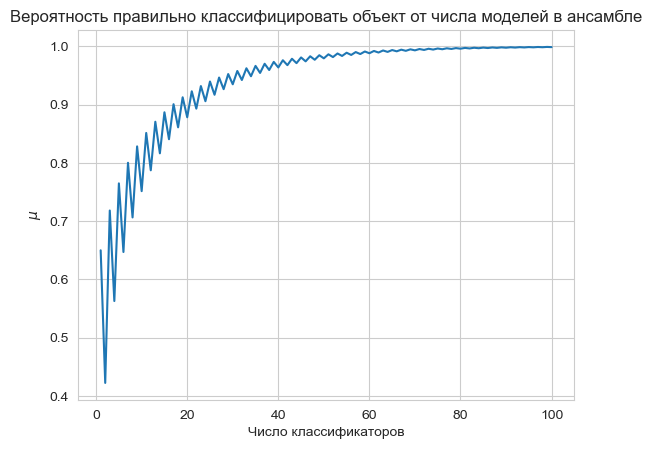

In [56]:
p = 0.65
mu = []
num_of_models = np.arange(1, 101)

for num in num_of_models:
    mu.append(np.sum(np.array([math.comb(num, i) * pow(p, i) * pow(1-p, num-i) for i in range(num//2 + 1, num+1)])))
    
plt.plot(num_of_models, mu)
plt.xlabel("Число классификаторов");
plt.ylabel("$\mu$");
plt.title("Вероятность правильно классифицировать объект от числа моделей в ансамбле");




Опишите ваши наблюдения:

* Ансамбли из большого числа классификаторов позволяют добиться очень высокой точности при небольшой точности отдельных классификаторов
* Начиная с какого-то числа классификаторов в ансамбле (~80 в нашем примере), точность выходит на плато

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [57]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i) # fix random seed
            # select max_features features without replacement
            feature_ids = np.random.choice(np.arange(X.shape[1]), size=self.max_features, replace=False)
            #save feature indices to the list (self.feat_ids_by_tree)                                        
            self.feat_ids_by_tree.append(feature_ids)
           # create a bootstrap sample
            pseudosample = np.random.choice((X.shape[0]), size=X.shape[0], replace=True)
  
            clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                       max_features=self.max_features,
                                         random_state=self.random_state+i)
            #fir the classifier
            clf.fit(X[pseudosample][:, feature_ids], y[pseudosample])
            self.trees.append(clf)

            return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        y_pred = []
        for clf, features in zip(self.trees, self.feat_ids_by_tree):
            y_pred.append(clf.predict_proba(X[:,features]))
        return np.average(y_pred, axis=0)        
 
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions     


Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [60]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

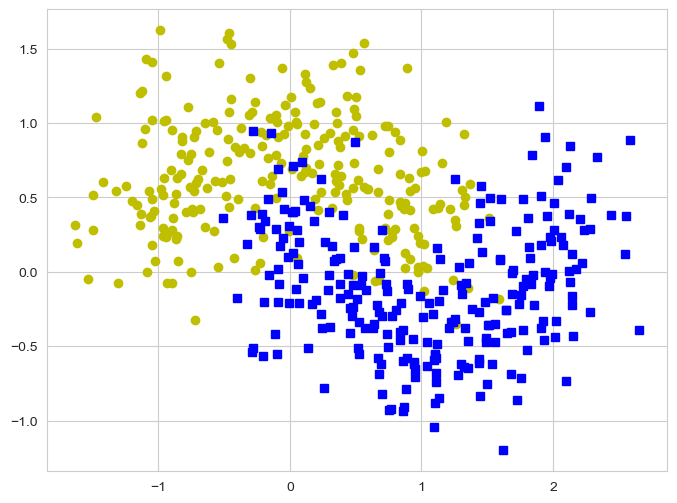

In [61]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

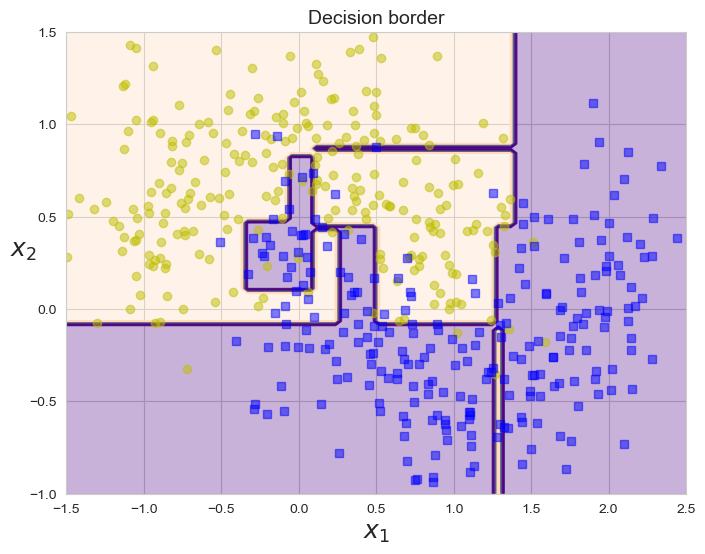

In [64]:
#try for 1 set of parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(max_depth=8, max_features=X.shape[1], random_state=SEED)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show() 

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

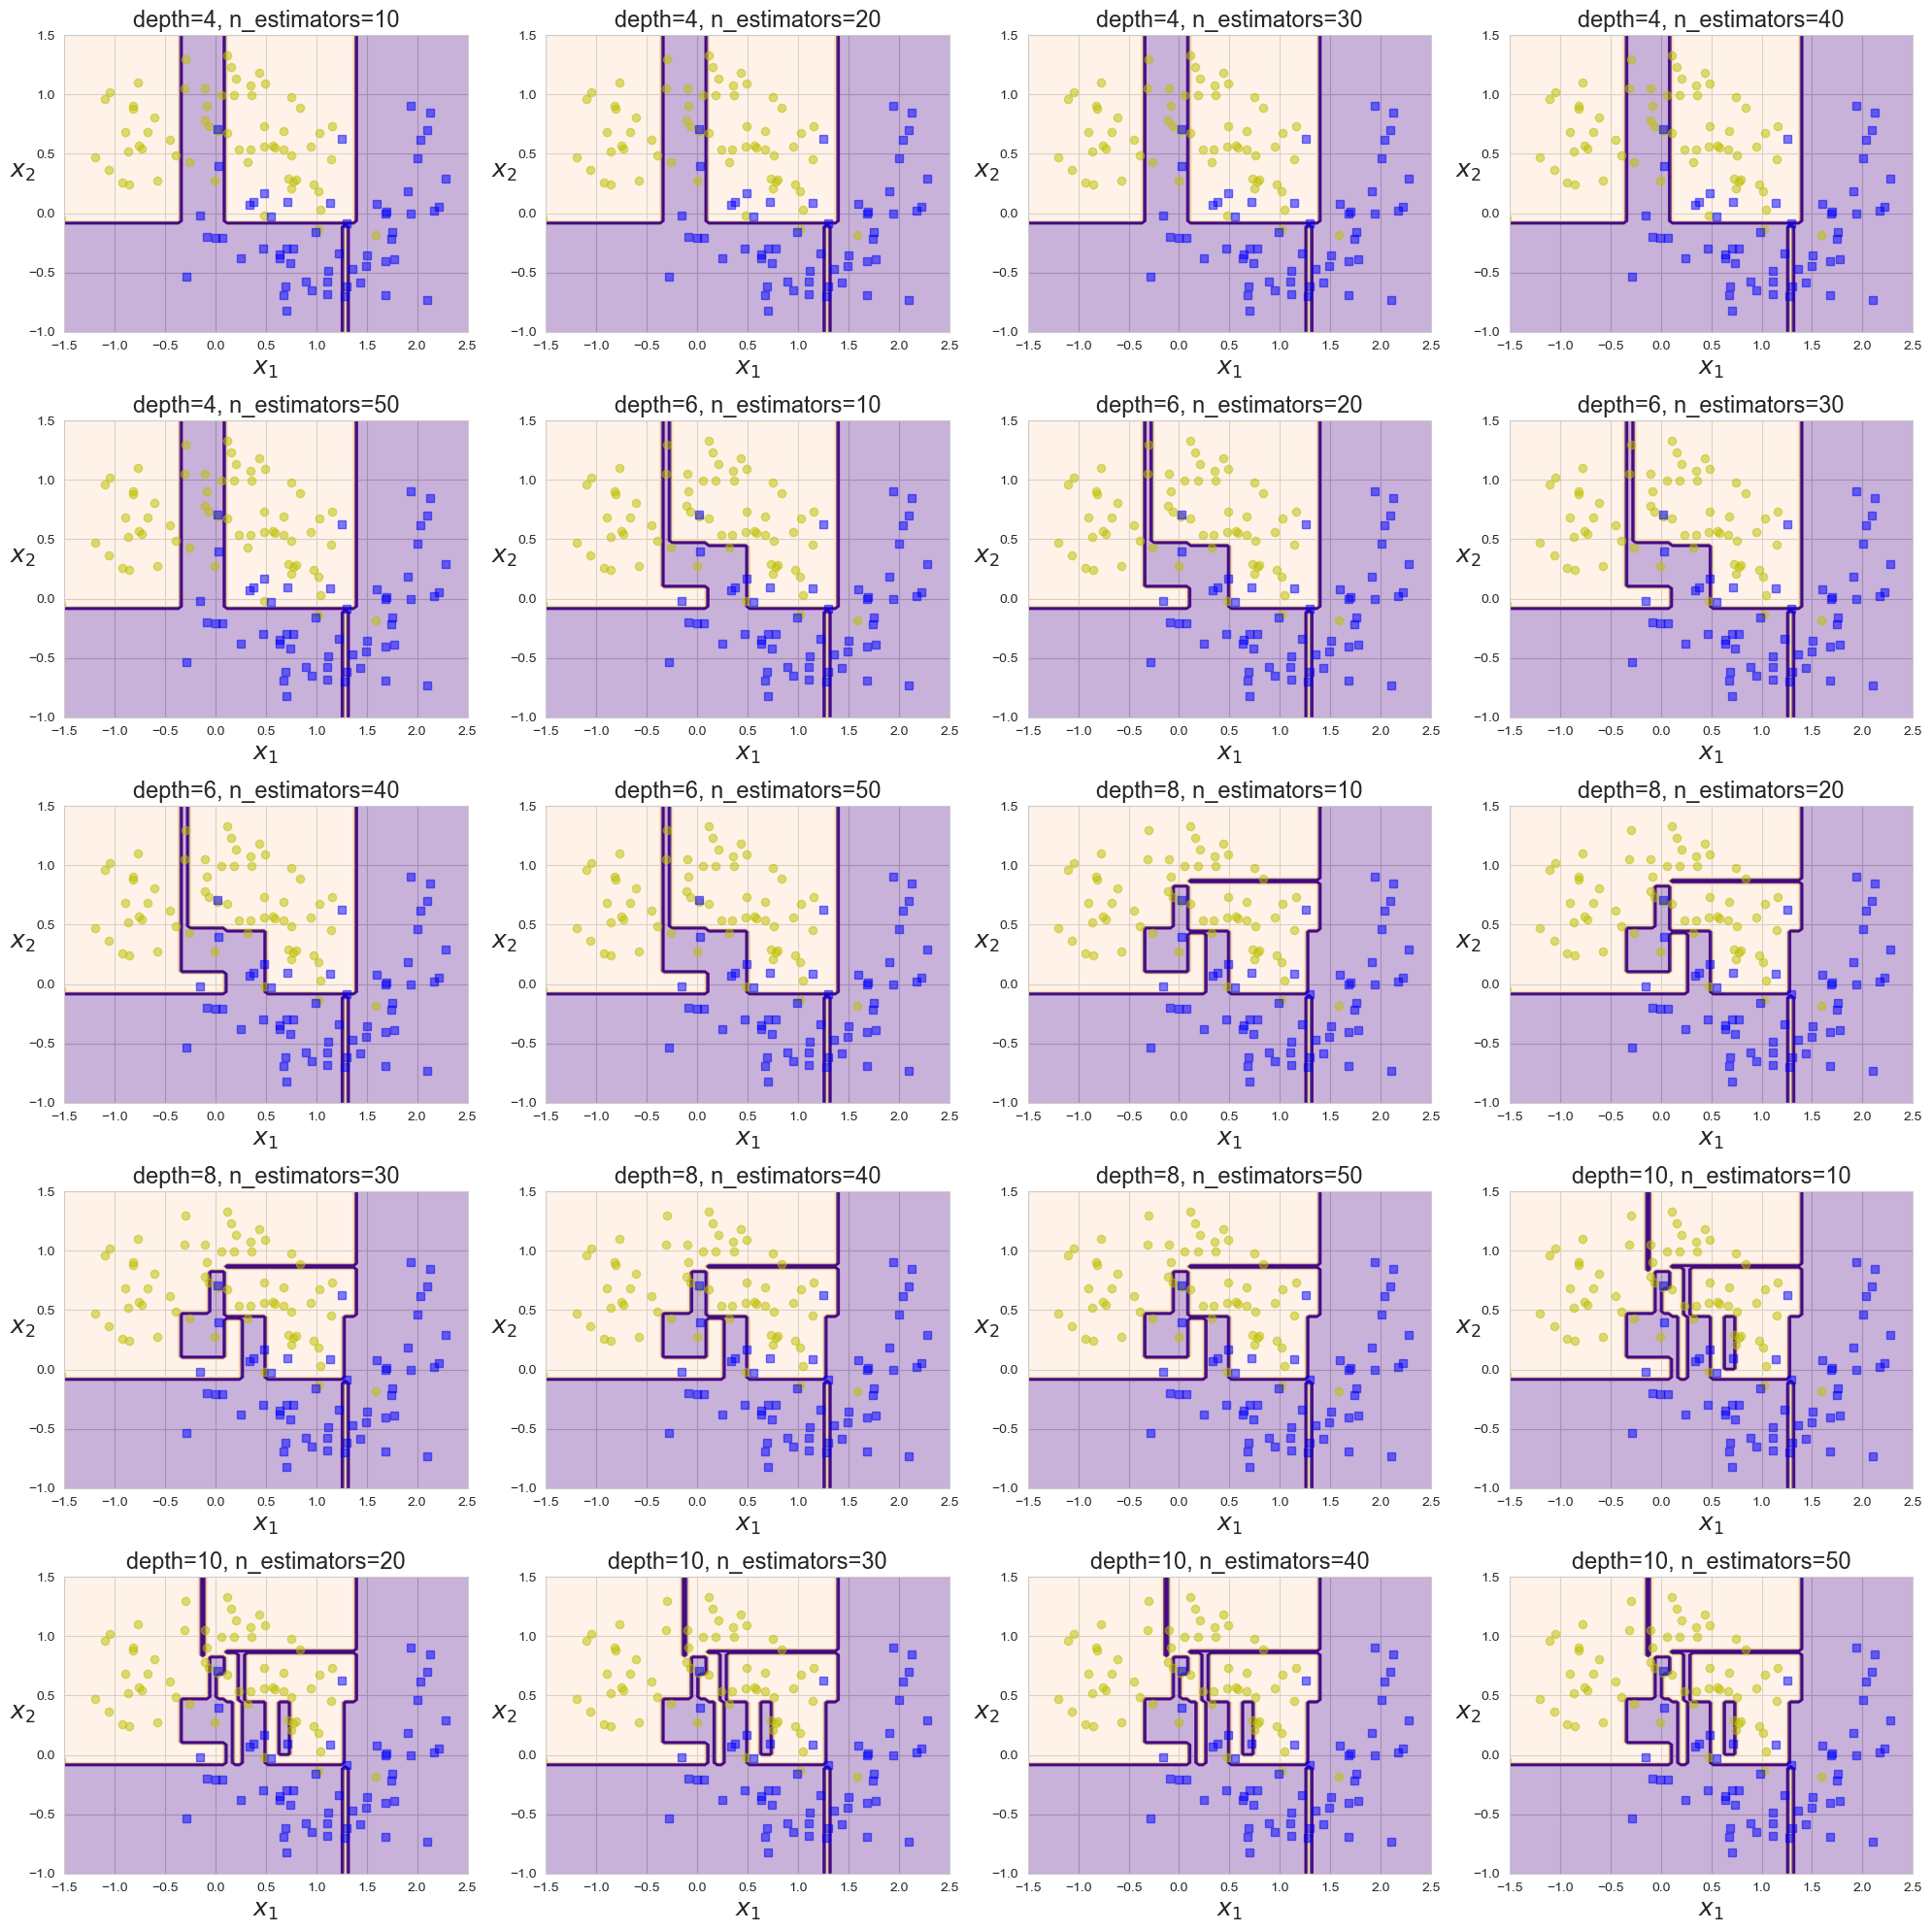

In [82]:
plt.figure(figsize=(20, 20))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
ind = 1
for depth in range(4, 12, 2):
    for estim in range(10, 60, 10):
        clf = RandomForestClassifierCustom(max_depth=depth, max_features=2, n_estimators=estim)
        clf.fit(X_train, y_train)
        plt.subplot(5, 4, ind)
        plot_decision_boundary(clf, X_test, y_test)
        plt.title(f'depth={depth}, n_estimators={estim}', size=17)
        ind += 1
        plt.tight_layout()        
plt.show();



Результат не очень красивый в целом

Неплохо на глубине 8, а число эстиматоров повлияло не сильно

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [83]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [84]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [86]:
# overall number of features
X.shape[1]

30

In [91]:
pd.DataFrame(np.array(corr_coeffs).T, columns=range(1,21))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.701721,0.884913,0.776112,0.823123,0.765453,0.838143,0.855359,0.737822,0.795271,0.781940,0.897039,0.810793,0.852675,0.825457,0.750552,0.884913,0.911946,0.840894,0.827711,0.755437
1,0.701721,0.771289,0.781550,0.761539,0.821752,0.823892,0.798023,0.735837,0.847613,0.838937,0.911946,0.838937,0.868398,0.838937,0.795798,0.885529,0.885559,0.869995,0.784221,0.812225
2,0.762639,0.706851,0.777257,0.769997,0.893896,0.840894,0.841790,0.753589,0.881768,0.739309,0.897039,0.854141,0.778388,0.880982,0.794925,0.798023,0.912891,0.855715,0.841790,0.869995
3,0.722940,0.775058,0.814548,0.835846,0.863548,0.955936,0.870826,0.778513,0.838292,0.795271,0.780646,0.824283,0.778388,0.809475,0.752851,0.827418,0.882594,0.797334,0.841759,0.840894
4,0.577276,0.881818,0.748849,0.734466,0.808382,0.852675,0.812060,0.730936,0.871603,0.824312,0.911946,0.839450,0.796079,0.882228,0.781940,0.855715,0.796178,0.798023,0.784194,0.828087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,0.701456,0.793571,0.857687,0.840990,0.871575,0.812060,0.869228,0.870701,0.743566,0.885559,0.798396,0.819094,0.723762,0.799227,0.882999,0.824969,0.792113,0.867591,0.769536,0.927384
4946,0.768375,0.823123,0.866686,0.811029,0.762351,0.752130,0.825356,0.826346,0.796178,0.838143,0.870574,0.808176,0.780646,0.812225,0.821752,0.794925,0.811038,0.823892,0.839954,0.844786
4947,0.669641,0.793295,0.899643,0.813388,0.842448,0.788293,0.824283,0.830172,0.771737,0.841759,0.825457,0.895621,0.738945,0.799227,0.870701,0.805770,0.781405,0.896336,0.783874,0.847059
4948,0.696168,0.852860,0.853641,0.780067,0.702828,0.791619,0.868431,0.783859,0.738945,0.853641,0.841525,0.882228,0.796178,0.782924,0.786949,0.721688,0.767951,0.852675,0.794925,0.815968


In [93]:
np.arange(1,21)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

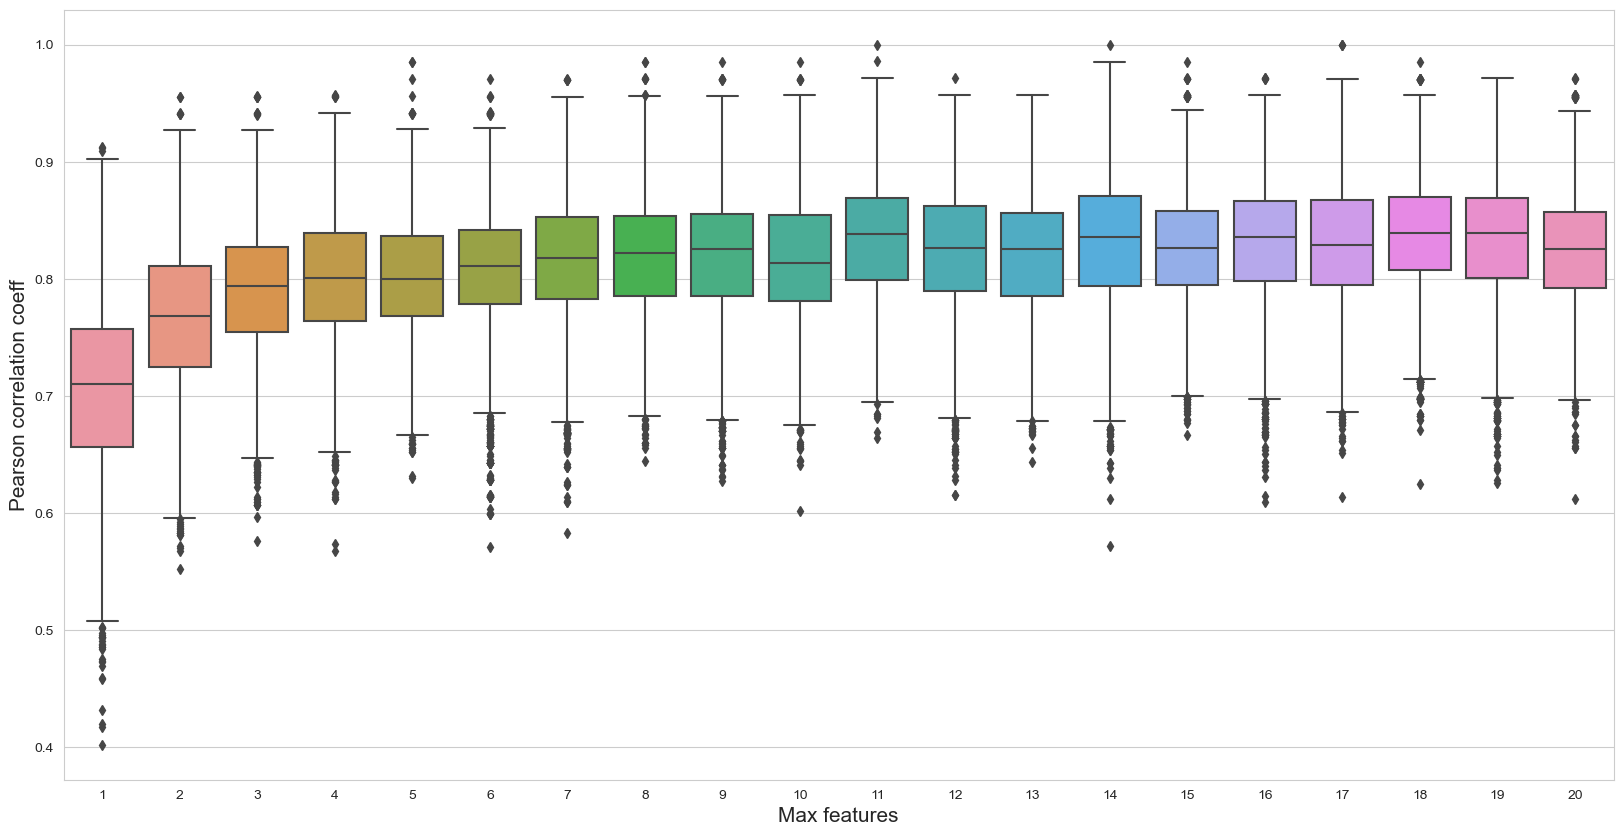

In [98]:
corr_coeffs = []
for features in range(1, 21):
    clf = RandomForestClassifier(max_features=features)
    clf.fit(X_train, y_train)
    corr_coeffs.append(base_model_pair_correlation(clf, X_test))

plt.figure(figsize=(20, 10))

data=pd.DataFrame(np.array(corr_coeffs).T, columns=np.arange(1,21))
sns.boxplot(data=data)
plt.xlabel('Max features', size=15)
plt.ylabel('Pearson correlation coeff', size=15)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

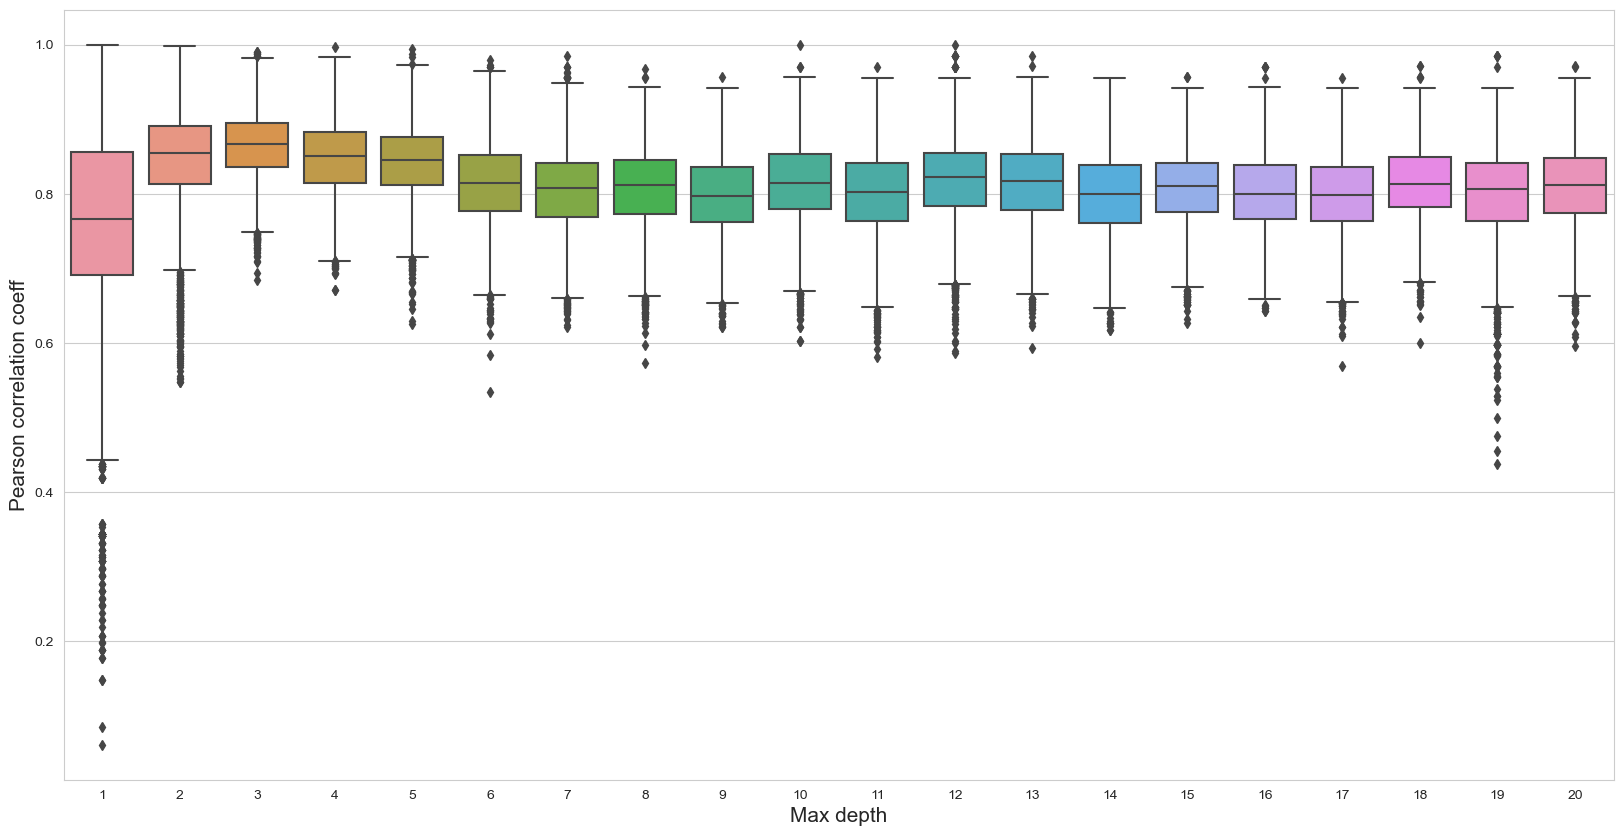

In [99]:
corr_coeffs = []
for max_depth in range(1, 21):
    clf = RandomForestClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    corr_coeffs.append(base_model_pair_correlation(clf, X_test))
plt.figure(figsize=(20, 10))

data=pd.DataFrame(np.array(corr_coeffs).T, columns=np.arange(1,21))
sns.boxplot(data=data)
plt.xlabel('Max depth', size=15)
plt.ylabel('Pearson correlation coeff', size=15)
plt.show()    


Опишите ваши наблюдения:

*  ~~Чем дальше в лес~~  Чем больше max_features, тем сильнее корреляция деревьев, причем начиная с 8-9, значения коэффициента выходит на плато. Также при маленьких значениях большой разброс

* С увеличением глубины от 1 до ~3, корреляция возрастает, дальше снижается с выходом на плато, начиная с глубины 7-8. Т.е. оптимальная глубина ~3. При значении 1-2 большой разброс - т.е. случайно можно получить как очень похожие, так и непохожие классификаторы

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [7]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("C:\\Users\\Roman\\Downloads\\heart.csv")

In [8]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


In [9]:
X.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

Ну и ок, сделаем scaling

In [42]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [57]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()
#wow
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [111]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')


## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8363881261208969
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.8431955211024978
SVC: 0.8439024390243902
SVC: 0.8536521565187956
XGBClassifier: 0.8250559091466579
LGBMClassifier: 0.8203861590709383
XGBRFClassifier: 0.8379629629629629
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignore

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [113]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [114]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_soft.fit(X_train, y_train)
base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8075082819576243),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7749544834941164),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.6497945491547565),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.71854672419034),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.731613116464304),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.7872535788811531),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.827885572904833),
 (De

In [115]:
voting_hard.fit(X_train, y_train)
base_model_pair_correlation_for_voting_clf(voting_hard, X_test)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8075082819576243),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7749544834941164),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.6497945491547565),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.71854672419034),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.731613116464304),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.7872535788811531),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.827885572904833),
 (De

Gridsearch уж очень долго идет, я просто решила оставить несколько моделей, которые меньше всего коррелируют с другими

In [26]:
from sklearn.metrics import f1_score

In [24]:
# base_models_fin = [("SVC_RBF", svc_rbf), 
#                ("XGB", xgb), ("ETC", etc)]

# base_models_fin = [("CAT", cat), ("NB", nb), ("SVC_RBF", svc_rbf), 
#                ("XGB", xgb)]

base_models_fin = [("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("NB", nb)]

voting_soft = VotingClassifier(estimators=base_models_fin, voting='soft')
voting_soft.fit(X_train, y_train)

scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")


VotingClassifier: 0.8486195713160681


In [28]:
y_pred = voting_soft.predict(X_test)
print(f"sklearn f1_score: {f1_score(y_test, y_pred)}")

sklearn f1_score: 0.8979591836734694


Вообще f1_score из sklearn-a дал скор выше 0.89

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [25]:
data = pd.read_csv("C:\\Users\\Roman\\Downloads\\churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [30]:
data.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [31]:
print(data.nunique())

State               51
Account Length     212
Area Code            3
Phone             3333
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64


In [36]:
#Encoding
from sklearn.preprocessing import LabelEncoder

In [37]:
lb = LabelEncoder()

data["Int'l Plan"] = lb.fit_transform(data["Int'l Plan"])
data["VMail Plan"] = lb.fit_transform(data["VMail Plan"])


In [39]:
# А churn вручную заэнкодим
data["Churn?"].replace({'False.': 0, 'True.': 1}, inplace=True)

In [40]:
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Дропнем Area Code, Phone, Int'l Plan, VMail Plan

In [41]:
X = data.copy().drop(['State', 'Phone', 'Churn?'], axis = 1)
y = data["Churn?"]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Scaling - хуже не будет

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Catboost мой любимый, начну с него

In [49]:
from catboost import CatBoostClassifier

In [50]:
CBC = CatBoostClassifier()   

In [51]:
parameters = {'depth'         : [4,5,6,7],
                 'learning_rate' : [0.01, 0.03,0.07],
                  'iterations'    : [10, 50, 100, 200]
                 }

In [54]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(X_train, y_train)

0:	learn: 0.6383705	total: 11.5ms	remaining: 2.3s
1:	learn: 0.5773938	total: 20.3ms	remaining: 2.01s
2:	learn: 0.5221675	total: 28ms	remaining: 1.84s
3:	learn: 0.4727168	total: 36.1ms	remaining: 1.77s
4:	learn: 0.4318488	total: 45.8ms	remaining: 1.79s
5:	learn: 0.4073168	total: 53.7ms	remaining: 1.74s
6:	learn: 0.3849508	total: 62.8ms	remaining: 1.73s
7:	learn: 0.3622152	total: 70.8ms	remaining: 1.7s
8:	learn: 0.3427332	total: 79.6ms	remaining: 1.69s
9:	learn: 0.3293866	total: 89.7ms	remaining: 1.7s
10:	learn: 0.3168811	total: 98.2ms	remaining: 1.69s
11:	learn: 0.3096954	total: 104ms	remaining: 1.63s
12:	learn: 0.2944369	total: 111ms	remaining: 1.6s
13:	learn: 0.2851550	total: 120ms	remaining: 1.59s
14:	learn: 0.2750463	total: 126ms	remaining: 1.55s
15:	learn: 0.2677270	total: 133ms	remaining: 1.53s
16:	learn: 0.2614588	total: 139ms	remaining: 1.49s
17:	learn: 0.2543374	total: 145ms	remaining: 1.47s
18:	learn: 0.2471249	total: 154ms	remaining: 1.47s
19:	learn: 0.2400780	total: 163ms	re

161:	learn: 0.1077141	total: 1.27s	remaining: 299ms
162:	learn: 0.1072917	total: 1.28s	remaining: 291ms
163:	learn: 0.1069585	total: 1.29s	remaining: 283ms
164:	learn: 0.1065001	total: 1.29s	remaining: 275ms
165:	learn: 0.1061229	total: 1.3s	remaining: 267ms
166:	learn: 0.1054376	total: 1.31s	remaining: 259ms
167:	learn: 0.1053838	total: 1.32s	remaining: 251ms
168:	learn: 0.1051582	total: 1.32s	remaining: 243ms
169:	learn: 0.1050889	total: 1.33s	remaining: 235ms
170:	learn: 0.1041273	total: 1.34s	remaining: 228ms
171:	learn: 0.1040590	total: 1.36s	remaining: 221ms
172:	learn: 0.1036529	total: 1.37s	remaining: 214ms
173:	learn: 0.1031956	total: 1.39s	remaining: 207ms
174:	learn: 0.1027159	total: 1.4s	remaining: 200ms
175:	learn: 0.1024086	total: 1.41s	remaining: 192ms
176:	learn: 0.1020474	total: 1.42s	remaining: 185ms
177:	learn: 0.1016844	total: 1.44s	remaining: 178ms
178:	learn: 0.1013647	total: 1.45s	remaining: 170ms
179:	learn: 0.1010313	total: 1.46s	remaining: 162ms
180:	learn: 0.

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000225EBA8D5E0>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7],
                         'iterations': [10, 50, 100, 200],
                         'learning_rate': [0.01, 0.03, 0.07]})

In [55]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.9523630907726932

 The best parameters across ALL searched params:
 {'depth': 5, 'iterations': 200, 'learning_rate': 0.07}


Catboost лучший

In [59]:
from xgboost import XGBRFClassifier

In [62]:
xgb = XGBRFClassifier()

parameters = {
    "n_estimators": [10, 50, 100],
    "max_depth": [2, 4, 6, 8],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.3, 0.5, 0.9],
    "learning_rate": [0.01, 0.03,0.07],
}


grid_xgb = GridSearchCV(
    xgb, param_grid=parameters, cv=3, n_jobs=-1
)
grid_xgb.fit(X_train, y_train)



 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.9523630907726932

 The best parameters across ALL searched params:
 {'depth': 5, 'iterations': 200, 'learning_rate': 0.07}


In [63]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgb.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.03, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=10, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

 The best score across ALL searched params:
 0.9489886399335218

 The best parameters across ALL searched params:
 {'learning_rate': 0.03, 'max_depth

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

### What junior data scientists do?

    model.fit()

    model.predict()

### What senior data scientists do?

    for model in models:

      model.fit()
  
      model.predict()